**Clasificación supervisada de las zonas de riesgo en Barcelona.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score, f1_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import shapiro
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

from joblib import dump 

In [2]:
df = pd.read_csv('dades_EDA.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21054 entries, 0 to 21053
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   districte          21054 non-null  object 
 1   barri              21054 non-null  object 
 2   espai_id           21054 non-null  int64  
 3   data               21054 non-null  object 
 4   hora               21054 non-null  object 
 5   franja_horaria     21054 non-null  object 
 6   semafor            21054 non-null  object 
 7   num_no_binari      21054 non-null  int64  
 8   punt_trobada       21054 non-null  float64
 9   proximitat_recurs  21054 non-null  float64
 10  lloc_pernocta      21054 non-null  float64
 11  zonas              21054 non-null  object 
 12  homes              21054 non-null  int64  
 13  dones              21054 non-null  int64  
 14  consum             21054 non-null  float64
 15  estacio            21054 non-null  object 
dtypes: float64(4), int64(4

Se carga el dataframe contiene 21344 filas y 30 columnas

# Preprocesado

Variable target = semafor
Las variables de categóricas deben pasar a numéricas para poder aplicar machine learning.
Se tendrá que trabajar la descompensación de la variable target.

In [5]:
df['semafor'].value_counts()

Verd       17268
Groc        2733
Vermell     1053
Name: semafor, dtype: int64

Se observa la descompensación entre las variables

In [6]:
# Seleccionar las filas que cumplen con las condiciones para eliminar
muestra_eliminar = df[(df['semafor'] == 'Verd') & (df['homes'] != 0) & (df['dones'] != 0) & (df['num_no_binari'] != 0)]

# Filtrar el DataFrame para excluir los valores
df = df.drop(muestra_eliminar.index)

In [8]:
# Seleccionar aleatoriamente filas del DataFrame filtrado
muestra_recortar = df[df['semafor'] == 'Verd'].sample(n=11000, random_state=42)

# Filtrar el DataFrame para excluir los valores seleccionados
df = df.drop(muestra_recortar.index)


Se aplican tecnicas de undersampling para abordar el desequilibrio de datos.

In [9]:
df['semafor'].value_counts()


Verd       6264
Groc       2733
Vermell    1053
Name: semafor, dtype: int64

In [10]:
#Se eliminan aquellas variables que no se consideran útiles para el estudio.
df.drop(['zonas', 'barri',  'data', 'hora', 'franja_horaria', 'estacio', 'districte'], axis=1, inplace=True)


En este caso es redundante incluir la variable data y hora: ya que se está introduciendo en la variable franja_horaria y en estacion, donde se han separado las diferentes estaciones del año. 
La variable barri también es redundante y puede llevar a la multicoliniealiedad, ya que se aporta el lugar concreto y el distrito. 

A la pregunta de si es redundante incluir el lugar concreto depende del contexto específico y la naturaleza de los datos. En otros estudios quizá no se considera relevante el lugar en el cual se detectan determinadas dinámicas, pero en este estudio sí que es relevante. 
 en determinados parques de un determinado barrio concreto, se pueden normalizar dinámicas disruptivas, que en otro no. Por ejemplo, en un parque del barrio del raval, que se detecte un alto número de personas consumidas puede entrar dentro de la normalidad, si se trata de un lugar que esta cercano a un recurso para drogodependientes, por ejemplo. Por lo tanto, se considerará de riesgo medio. Mientras que si de repente, en un barrio como sarrià, se detecta el mismo número de personas con la misma casuística, se considerará de riesgo alto.
Por ello, la variable del lugar concreto aporta información adicional, no agregar el lugar al modelo implicaría que no se aportando toda la información y provocaría que el modelo no funcionase adecuadamente.

In [11]:
from sklearn.preprocessing import LabelEncoder

# Instanciar el codificador de etiquetas
label_encoder = LabelEncoder()

# Codificar las etiquetas originales
df['espai_id'] = label_encoder.fit_transform(df['espai_id'])

# Obtener las etiquetas únicas
etiquetas_unicas = label_encoder.classes_

# Obtener los códigos correspondientes a las etiquetas únicas
codigos_etiquetas = label_encoder.transform(etiquetas_unicas)

# Mostrar las etiquetas únicas y sus códigos
for etiqueta, codigo in zip(etiquetas_unicas, codigos_etiquetas):
    print(f'Etiqueta: {etiqueta}, Código: {codigo}')


Etiqueta: 43112, Código: 0
Etiqueta: 58540, Código: 1
Etiqueta: 58601, Código: 2
Etiqueta: 58603, Código: 3
Etiqueta: 59022, Código: 4
Etiqueta: 59033, Código: 5
Etiqueta: 59035, Código: 6
Etiqueta: 59174, Código: 7
Etiqueta: 59175, Código: 8
Etiqueta: 59178, Código: 9
Etiqueta: 59179, Código: 10
Etiqueta: 59181, Código: 11
Etiqueta: 59182, Código: 12
Etiqueta: 59662, Código: 13
Etiqueta: 59663, Código: 14
Etiqueta: 59664, Código: 15
Etiqueta: 59665, Código: 16
Etiqueta: 59668, Código: 17
Etiqueta: 59676, Código: 18
Etiqueta: 59677, Código: 19
Etiqueta: 59678, Código: 20
Etiqueta: 61315, Código: 21
Etiqueta: 61319, Código: 22
Etiqueta: 74167, Código: 23
Etiqueta: 74178, Código: 24
Etiqueta: 74189, Código: 25
Etiqueta: 74191, Código: 26
Etiqueta: 74193, Código: 27
Etiqueta: 74196, Código: 28
Etiqueta: 74199, Código: 29
Etiqueta: 123768, Código: 30
Etiqueta: 123770, Código: 31
Etiqueta: 123772, Código: 32
Etiqueta: 123777, Código: 33
Etiqueta: 123781, Código: 34
Etiqueta: 123783, Código:

In [12]:
correspondencia = { 'Verd': 0,'Groc': 1, 'Vermell': 2}

# Iterar sobre los valores únicos de la columna 'semafor'
for valor in df['semafor'].unique():
    # Convertir el valor según la correspondencia y asignarlo de nuevo a la columna 'semafor'
    df.loc[df['semafor'] == valor, 'semafor'] = correspondencia[valor]
    
# Convertir la columna 'zonas' a tipo int
df['semafor'] = df['semafor'].astype(int)

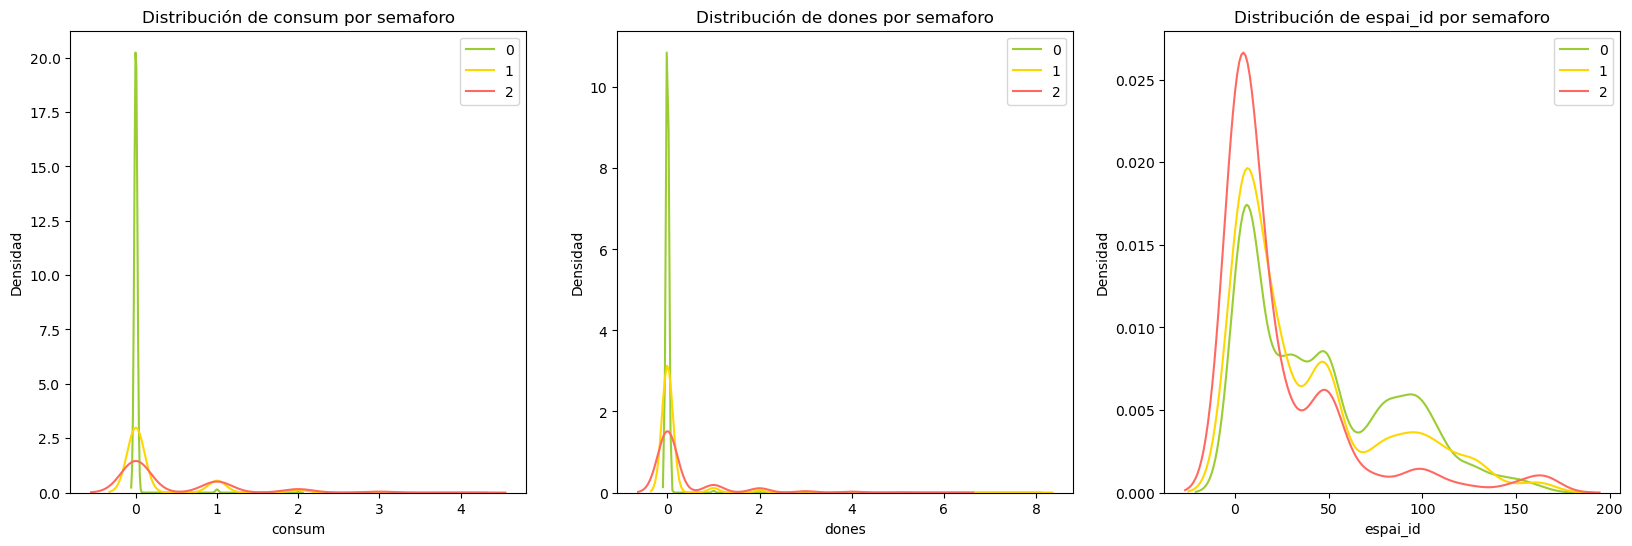

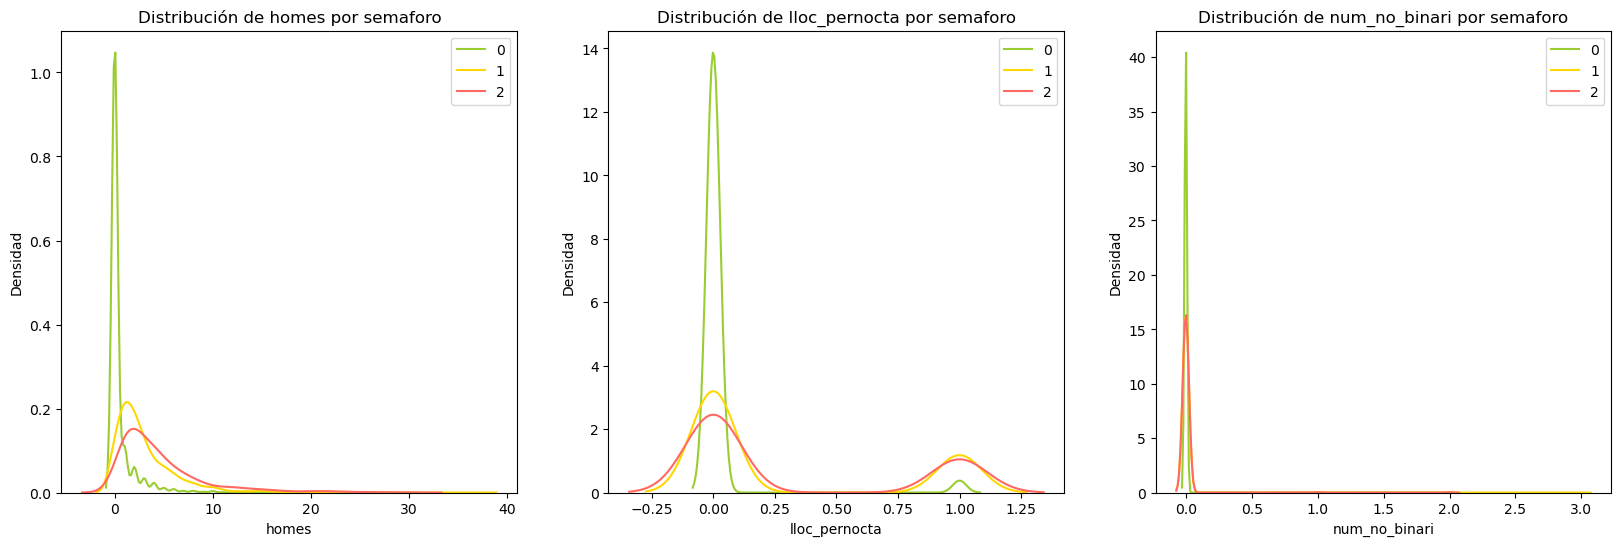

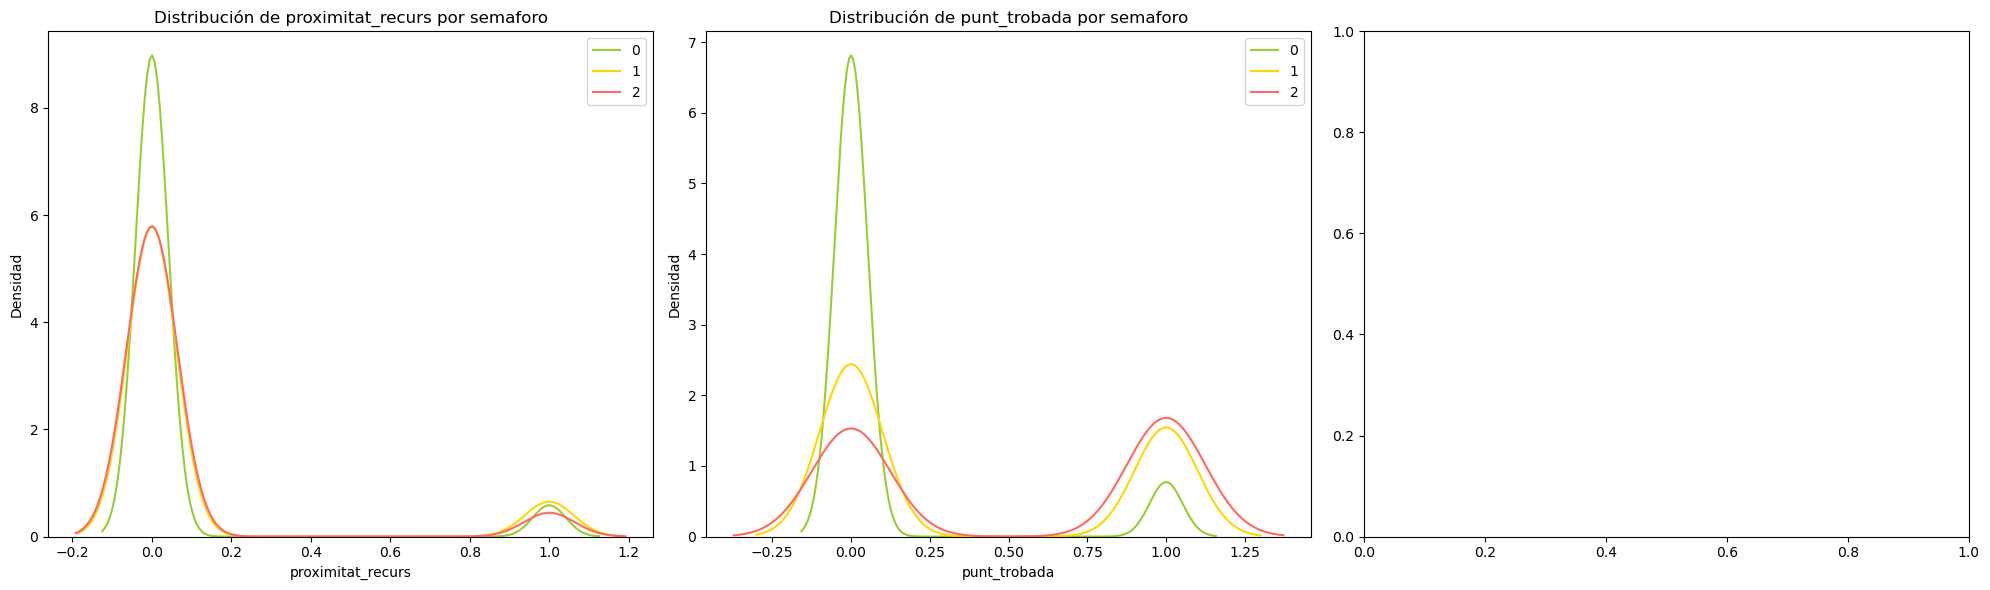

In [13]:
colores_semafor = {0: '#9ACD32', 1: '#FFD700', 2: '#FF6961'}


for i, columna in enumerate(df.columns.difference(['semafor'])):
    if i % 3 == 0:
        fig, axs = plt.subplots(1, 3, figsize=(20, 6))
        
    ax = axs[i % 3]
    
    for clasificacion in df['semafor'].unique():
        sns.kdeplot(df.loc[df['semafor'] == clasificacion, columna], label=f'{clasificacion}', ax=ax, color=colores_semafor[clasificacion])
    
    ax.set_title(f'Distribución de {columna} por semaforo')
    ax.set_xlabel(columna)
    ax.set_ylabel('Densidad')
    ax.legend()

plt.tight_layout()
plt.show()

Es interesante observar la distribución de las variables en relación a la variable target.

* Las variables binárias deberían tener una distribución parecida. Cuando la variable sea 0, no se detecte esa dinàmica, el color verde debería ser más alto, mientras que cuando se detecte, el rojo y/o el amarillo deberían estar por encima. Efectivamente, en la distribución de punt_trobada, lloc_pernocta y proximitat_recurs, así sucede. También sucede con la variable consumo, cuando no hay consumo, se concentran un gran número de riesgos bajos, mientras que cuando el consumo incrementa, el riesgo sube.

* Es relevante destacar como la variable de hombres, cuanto más próxima a cero más valores verdes, mientras que cuanto augmenta, es cuando empiezan a aparecer semáforos amarillos o rojos.

* La variable de personas no_binarias, es casi siempre practicamente 0, por lo que no aporta información adicional. Algo parecido pasa con las variables de mujeres, siendo tan reducido el número de registros, es poco perceptible su relación con la variable semáforo.

* La distribución de la variable espai_id, es interesante ya que demuestra que aquellos lugares con mayores registros (podría tratarse de zonas de raval) cuanta mayor es el registro, mayor será el número de registros rojos. Luego estan los lugares que tienen un registro medio, que normalemente acostumbran a ser verdes. Por último aquellos lugares que tienen pocos registros, y aquellos pocos son casi todos rojos. 

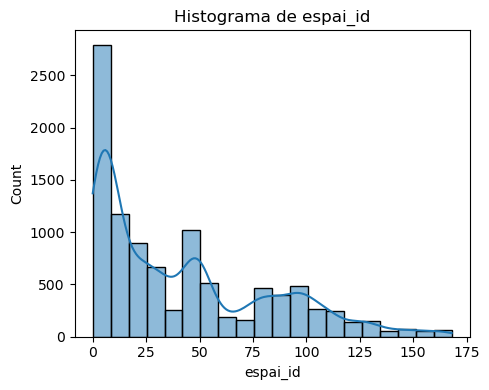

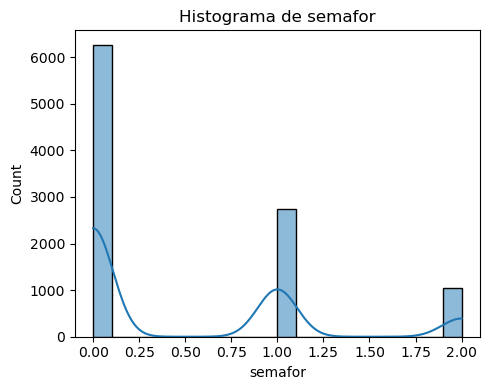

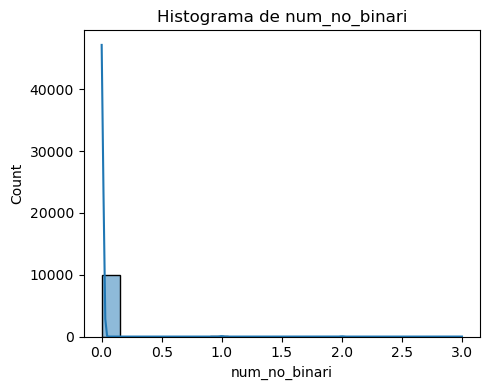

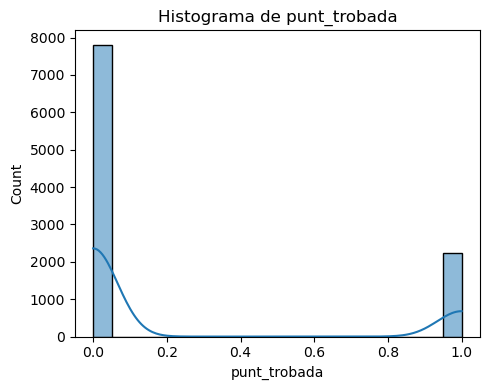

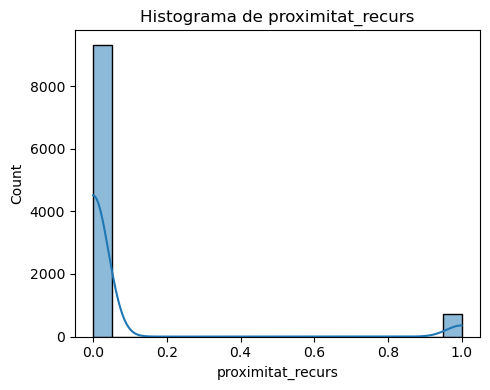

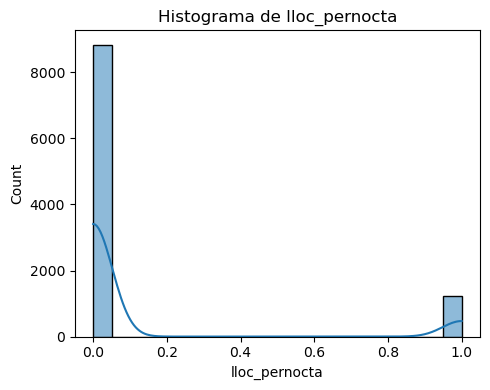

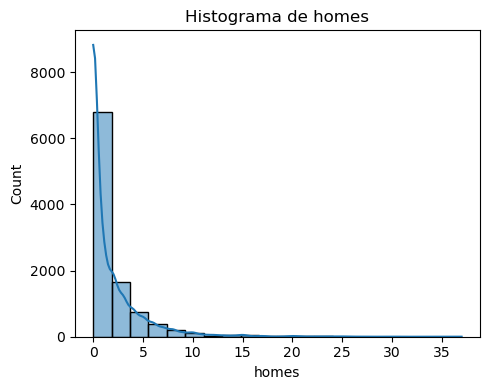

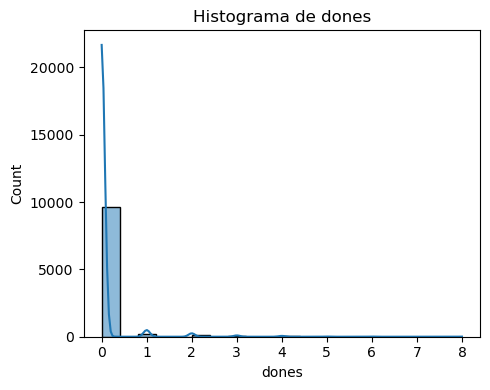

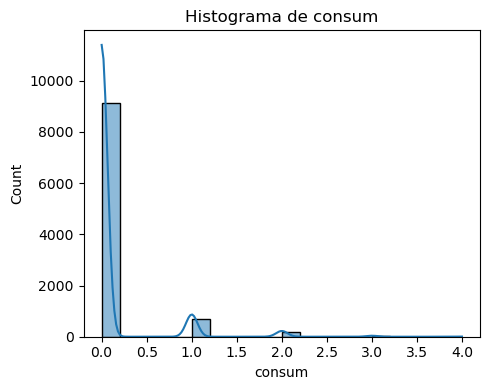

In [15]:
for variable in df.columns:
    plt.figure(figsize=(5, 4))
    sns.histplot(df[variable], kde=True, bins=20)
    plt.title(f'Histograma de {variable}')
    plt.xlabel(variable)
    plt.tight_layout()
    plt.show() 

En esta visualización se observa como hay una descompensación en el número de registros según el espacio, por lo que hay un desequilibrio en los lugares concretos registrados, provocando que haya lugares que esten sobre representados en relación a otros.
Además los registros binarios también se encuentran descompensados, ya que hay poca representación de dinámicas disruptivas (1), tanto en punt_trobada, proximitat_recurs como lloc_pernocta sucede lo mismo.
Algo parecido sucede con la variable de consumo, la descompensación de registros con 0 consumos, en relación a los pocos registros de consumo positivo. Dificultan la labor del modelo. 

In [16]:
df.drop(['num_no_binari'], axis=1, inplace=True)

Hay muy pocos registros de la variable personas no_binarias, por lo que no se tendrá en cuenta para no afectar al modelo

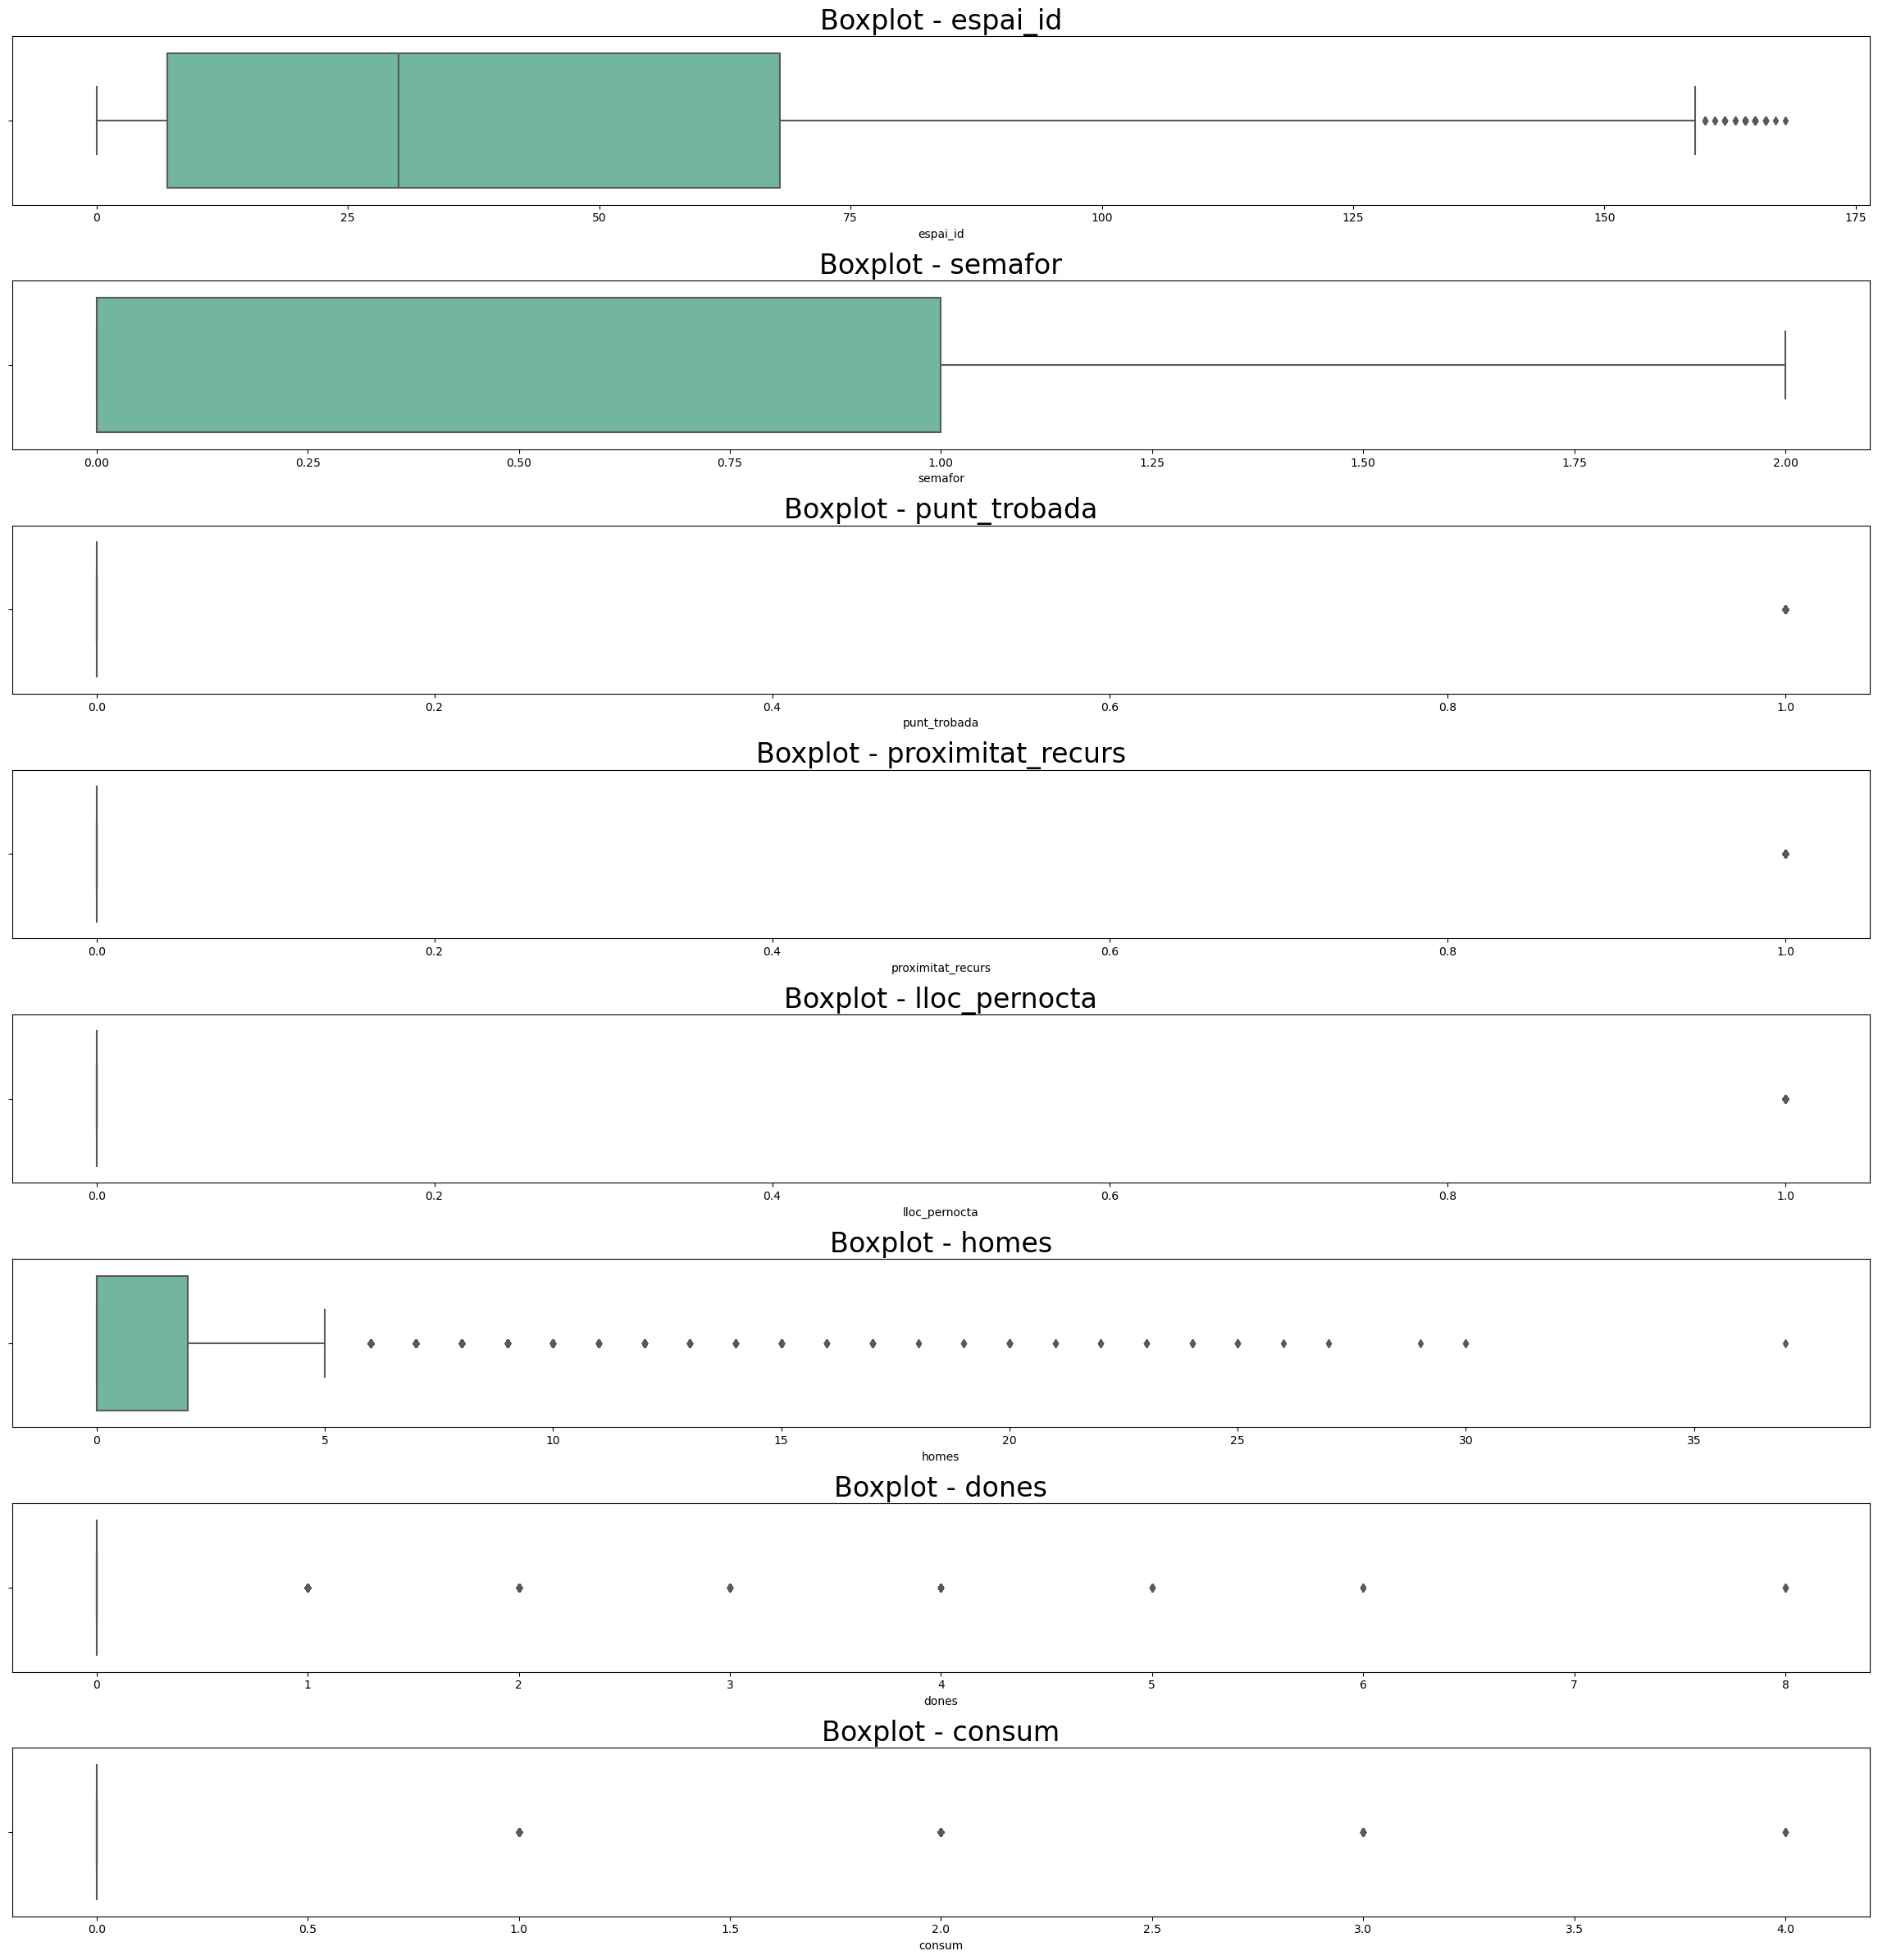

In [17]:
# Crear boxplots
num_rows = len(df.columns)
fig, axes = plt.subplots(num_rows, 1, figsize=(23, 3*num_rows))
palette = sns.color_palette("Set2")

for i, column in enumerate(df.columns):
    sns.boxplot(x=df[column], ax=axes[i], palette=palette) 
    axes[i].set_title(f'Boxplot - {column}' ,fontsize=24)

plt.tight_layout()
plt.show()


Se observa que las variables numéricas homes, dones tienen outliers por lo que se les aplica robustscaler.

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
espai_id,10050.0,41.473433,40.326949,0.0,7.0,30.0,68.0,168.0
semafor,10050.0,0.481493,0.677684,0.0,0.0,0.0,1.0,2.0
punt_trobada,10050.0,0.223582,0.416666,0.0,0.0,0.0,0.0,1.0
proximitat_recurs,10050.0,0.073035,0.260207,0.0,0.0,0.0,0.0,1.0
lloc_pernocta,10050.0,0.121194,0.326369,0.0,0.0,0.0,0.0,1.0
homes,10050.0,1.635025,2.942465,0.0,0.0,0.0,2.0,37.0
dones,10050.0,0.077114,0.448040,0.0,0.0,0.0,0.0,8.0
consum,10050.0,0.116418,0.403955,0.0,0.0,0.0,0.0,4.0


In [19]:
from sklearn.preprocessing import RobustScaler

# Seleccionar las columnas numéricas a escalar
columnas_num = ['homes','dones']

# Crea una instancia de RobustScaler
scaler = RobustScaler()

# Ajusta el escalador a los datos y transforma las columnas seleccionadas
df[columnas_num] = scaler.fit_transform(df[columnas_num])

In [20]:
df.describe().T 

,count,mean,std,min,25%,50%,75%,max
espai_id,10050.0,41.473433,40.326949,0.0,7.0,30.0,68.0,168.0
semafor,10050.0,0.481493,0.677684,0.0,0.0,0.0,1.0,2.0
punt_trobada,10050.0,0.223582,0.416666,0.0,0.0,0.0,0.0,1.0
proximitat_recurs,10050.0,0.073035,0.260207,0.0,0.0,0.0,0.0,1.0
lloc_pernocta,10050.0,0.121194,0.326369,0.0,0.0,0.0,0.0,1.0
homes,10050.0,0.817512,1.471233,0.0,0.0,0.0,1.0,18.5
dones,10050.0,0.077114,0.448040,0.0,0.0,0.0,0.0,8.0
consum,10050.0,0.116418,0.403955,0.0,0.0,0.0,0.0,4.0


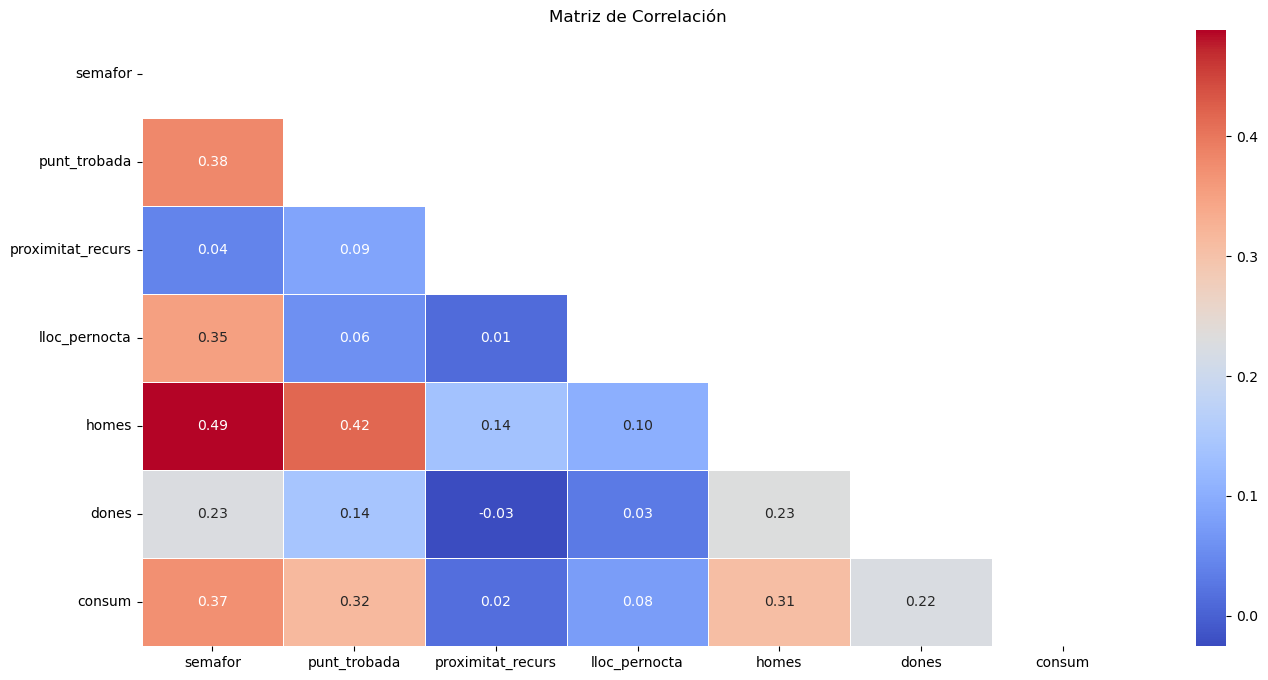

In [64]:
# Seleccionar solo las columnas numéricas relevantes para calcular la matriz de correlación
columnas_relevantes = df.drop('espai_id', axis=1)

# Calcular la matriz de correlación
matriz_correlacion = columnas_relevantes.corr()

# Crear el heatmap
plt.figure(figsize=(16, 8))
mask = np.triu(np.ones_like(matriz_correlacion, dtype=bool))
sns.heatmap(matriz_correlacion, annot=True, fmt=".2f", linewidth=.5, cmap='coolwarm', mask=mask)
plt.title('Matriz de Correlación')
plt.show()


* Azul: Indica correlaciones negativas, cuando una variable augmenta la otra disminuye
* Rojo:Indica correlaciones positivas, lo que significa que cuando una variable aumenta, la otra también tiende a aumentar.

Se detecta una correlación negativa pronunciada entre la variable semáforo y hombres. Puesto que cuanto mayor es el número de hombres que se detectan, mayor será el riesgo. También tiene sentido que exista una correlación negativa entre el semaforo y las variables punt de trobada o lloc de pernocta. Ya que cuando hay personas pernoctando en la calle o una acumulación de gente. El semáforo no estará en verde, sinó que el riesgo incrementará hacia el semáforo rojo. 

Tiene sentido que augmenten hacia la misma dirección las variables de proximitat_recurs con consum o lloc de pernocta. Puesto que normalmente cuando sucede una dinámica, se pueden producir varias a la vez.

In [22]:
#Guardar df en archivo csv
df.to_csv('dades_feb1.csv', index=False)

Text(0.5, 1.0, 'Correlación de variables con respecto a "semafor"')

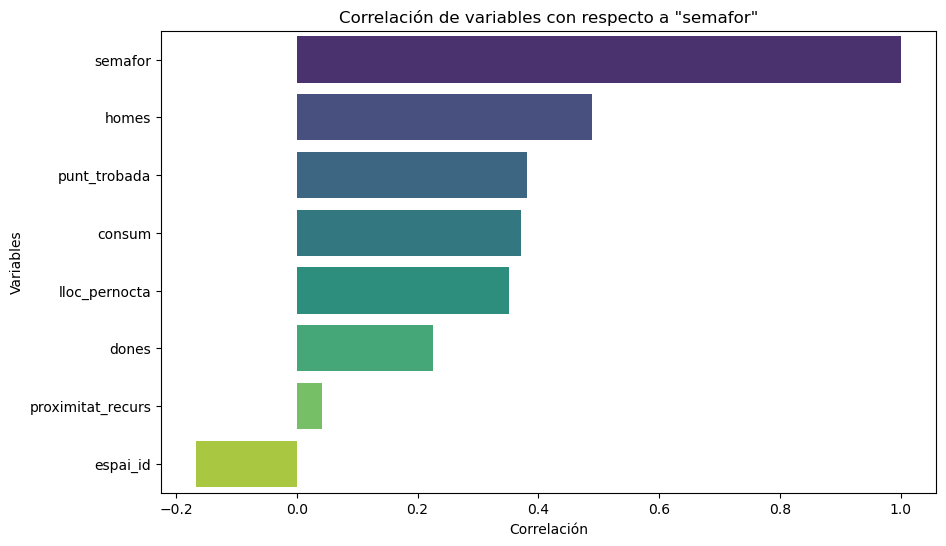

In [23]:
# Calcular la matriz de correlación
correlation_matrix = df.corr()

# Ordenar las variables por su correlación con una variable específica
sorted_variables = correlation_matrix['semafor'].sort_values(ascending=False)

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_variables.values, y=sorted_variables.index, palette='viridis')
plt.xlabel('Correlación')
plt.ylabel('Variables')
plt.title('Correlación de variables con respecto a "semafor"')


En esta gráfica se detectan las correlaciones de las variables en relación a la variable target.
Se observa que la que mayor correlación guarda es la de hombres, entre el 0,4 y 0,6. Seguida de punt_trobada, consum y lloc_pernocta. La que menor correlación tiene es la de proximitat_recurs. 
Por último se encuentra la de espai_id, que aunque esté en formato numérica se trata de una variable categórica por lo que no tiene relevancia en este caso.

In [24]:
#Se dividen los datos en conjuntos de entrenamiento y prueba
y = df['semafor']
X = df.drop('semafor', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Verificar la distribución de clases en y_train
clases_presentes = y_train.value_counts()
print(clases_presentes)


0    5022
1    2184
2     834
Name: semafor, dtype: int64


In [26]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar SMOTE solo a dos clases específicas 
smote = SMOTE(sampling_strategy={2: 5000, 1: 5000}, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

 Se aplican tecnicas de oversampling para abordar el desequilibrio de datos en los datos train. El test se deja con las variables descompensadas. Porque realmente lo que interesa es entrenar el modelo, por lo que se generar muestras sintéticas para las clases minoritarias para crear un conjunto de datos equilibrado.
 Las técnicas de oversampling y undersampling son métodos utilizados para abordar el desequilibrio de clases en conjuntos de datos, donde una clase es mucho más prevalente que otra. Estas técnicas serán útiles ya que como se apuntó anteriormente la distribución de las clases objetivo está desequilibrada, lo que puede llevar a un rendimiento deficiente del modelo en la predicción de las clases minoritarias.

In [27]:
# Verificar la distribución de clases en y_train
clases_presentes = y_train.value_counts()
print(clases_presentes)

0    5022
1    5000
2    5000
Name: semafor, dtype: int64


Se verifica el equilibrio una vez aplicadas las técnicas de under y oversampling.

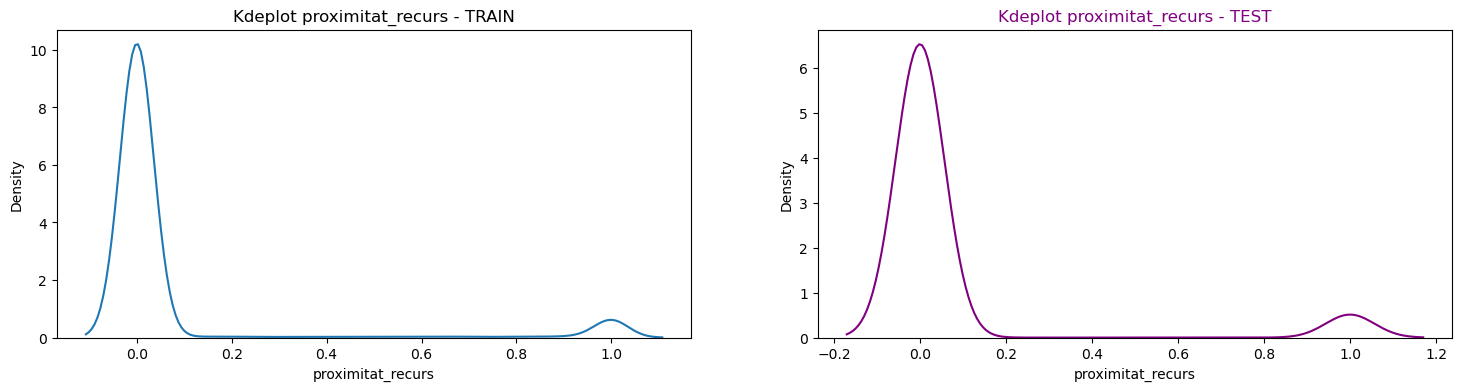

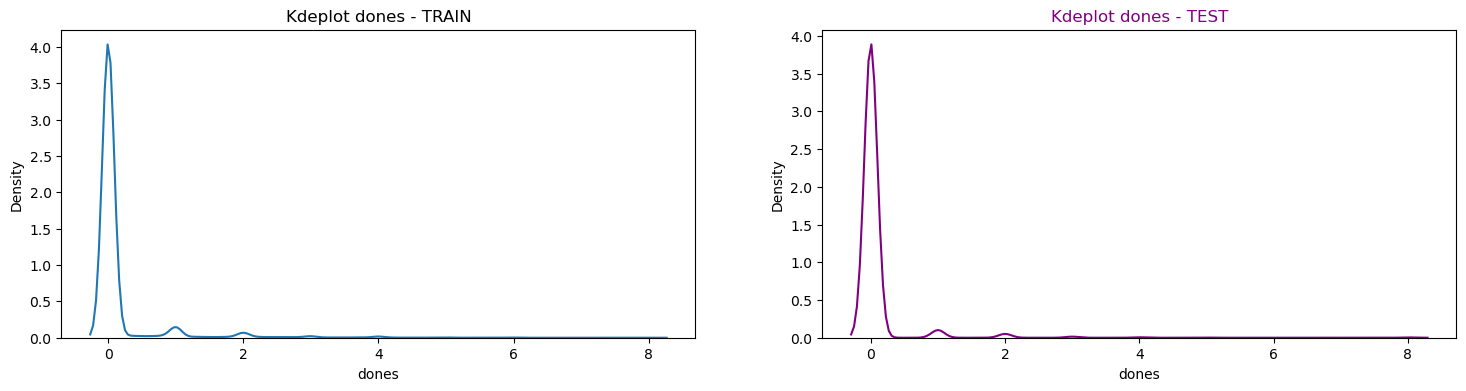

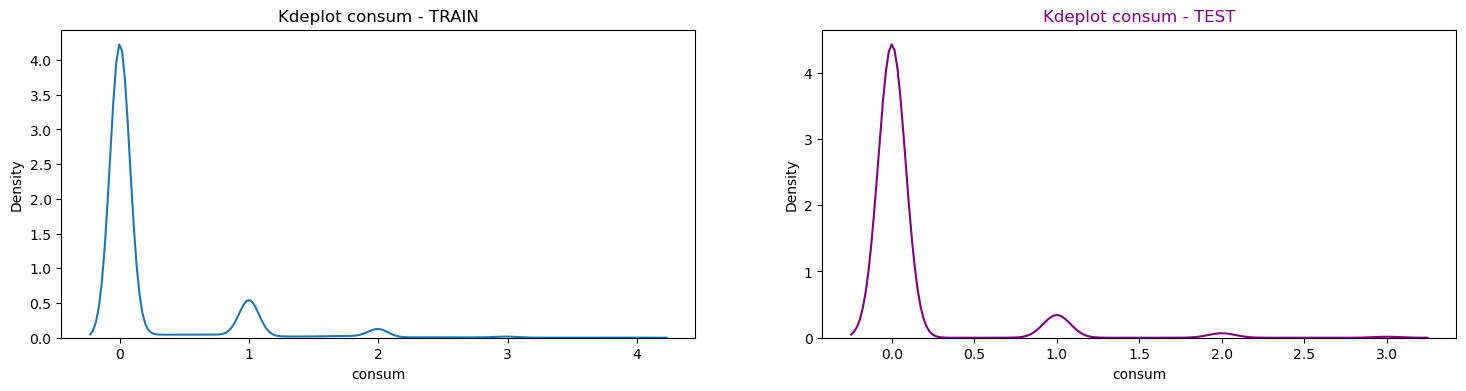

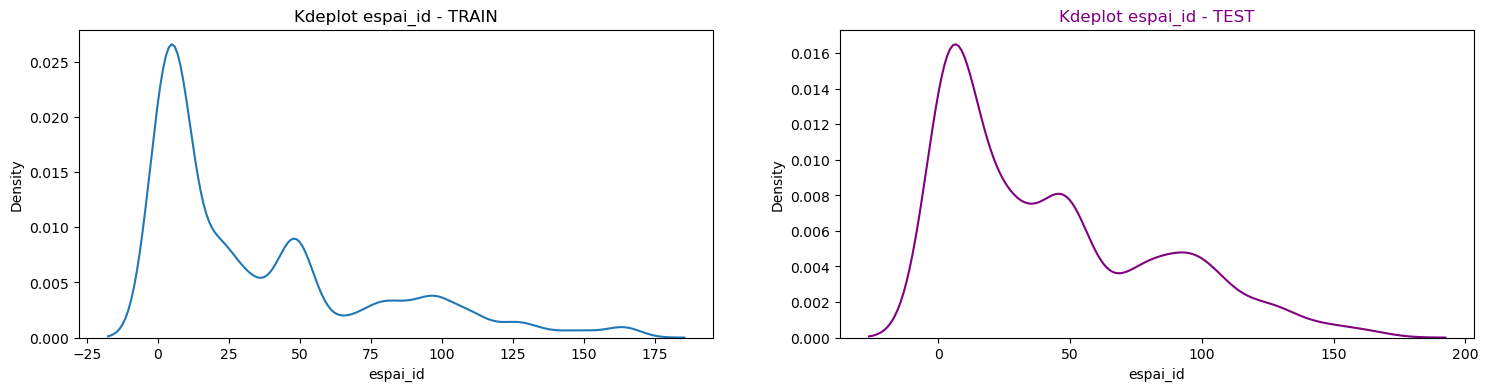

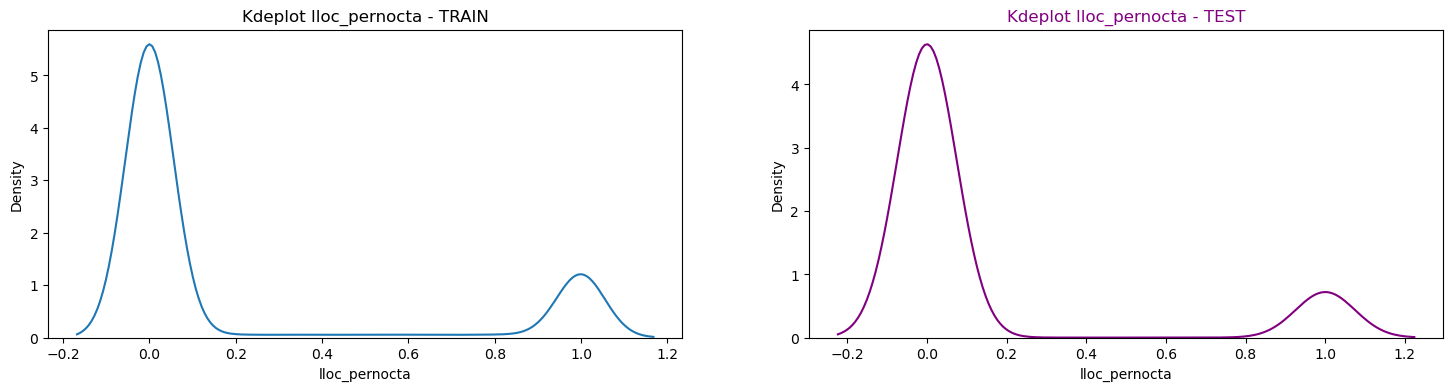

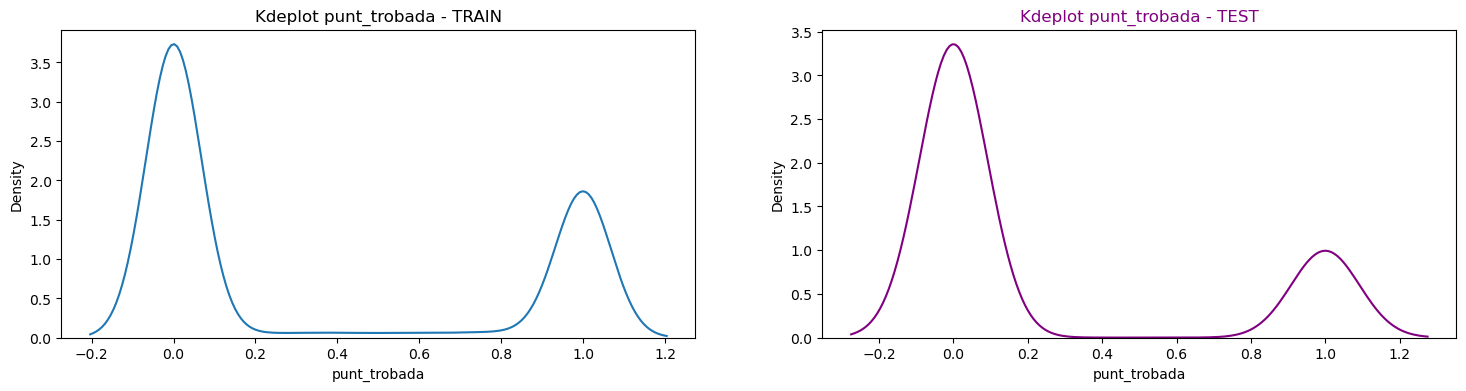

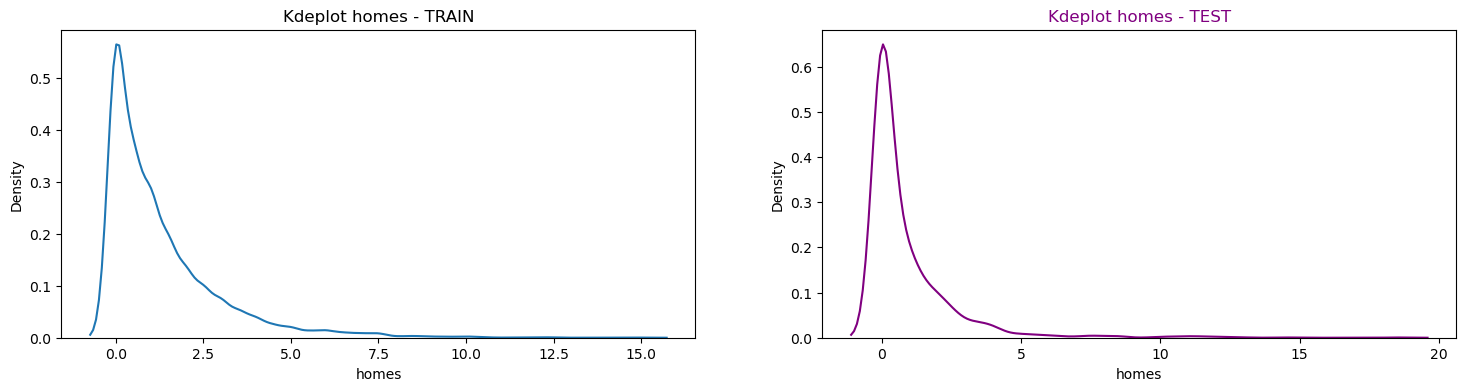

In [28]:
# lista de variables en común entre TRAIN y TEST
common_variables = set(X_train.columns).intersection(X_test.columns)

# Iterar sobre las variables
for variable in common_variables:
    plt.figure(figsize=(18, 4))

    plt.subplot(1, 2, 1)
    sns.kdeplot(X_train[variable]);
    plt.title(f'Kdeplot {variable} - TRAIN')
    plt.xlabel(variable)
    
    plt.subplot(1, 2, 2)
    sns.kdeplot(X_test[variable], color='purple');
    plt.title(f'Kdeplot {variable} - TEST', color='purple')
    plt.xlabel(variable)

Se comprueba que la distribución entre los datos de train y de test es igual. Por lo que se usaran los datos de train para entrenar el modelo y test para verificarlo.

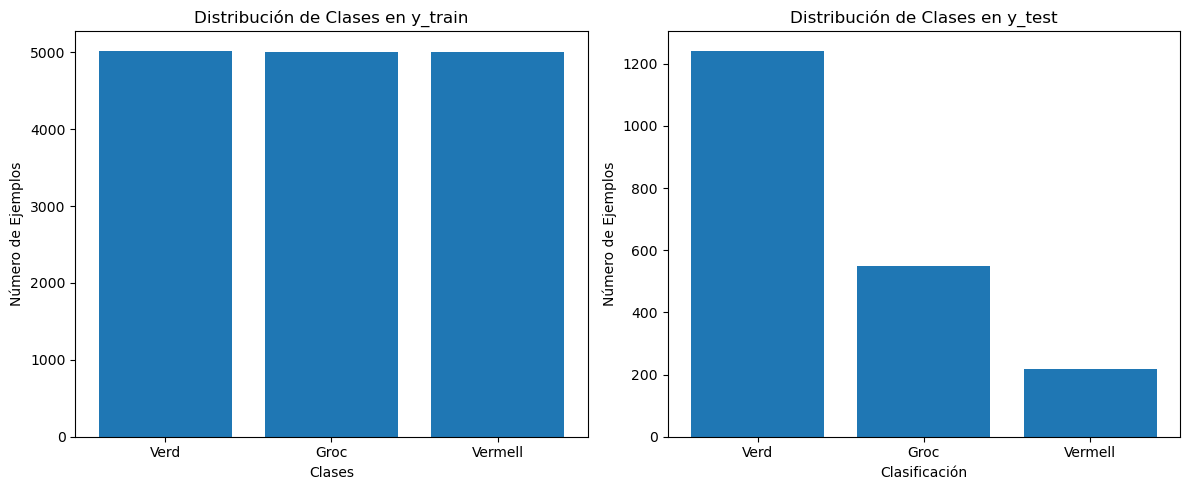

In [29]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
class_labels = ['Verd', 'Groc', 'Vermell']

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.bar(class_labels, counts_train)
plt.title('Distribución de Clases en y_train')
plt.xlabel('Clases')
plt.ylabel('Número de Ejemplos')

plt.subplot(122)
plt.bar(class_labels, counts_test)
plt.title('Distribución de Clases en y_test')
plt.xlabel('Clasificación')
plt.ylabel('Número de Ejemplos')

plt.tight_layout()


Se observa como las técnicas de oversampling y undersampling sirvieron para equilibrar las 3 clases de la variable target para entrenar el modelo. Mientras que el grupo test mantiene el desequilibrio del dataset original.

Model KNN:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1242
           1       0.56      0.59      0.58       549
           2       0.44      0.40      0.42       219

    accuracy                           0.74      2010
   macro avg       0.62      0.62      0.62      2010
weighted avg       0.74      0.74      0.74      2010

Model XGBoost:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1242
           1       0.57      0.66      0.61       549
           2       0.40      0.44      0.42       219

    accuracy                           0.74      2010
   macro avg       0.63      0.65      0.63      2010
weighted avg       0.76      0.74      0.75      2010

Model SVC:
              precision    recall  f1-score   support

           0       0.80      0.90      0.84      1242
           1       0.57      0.28      0.38       549
           2       0.36      0.55     

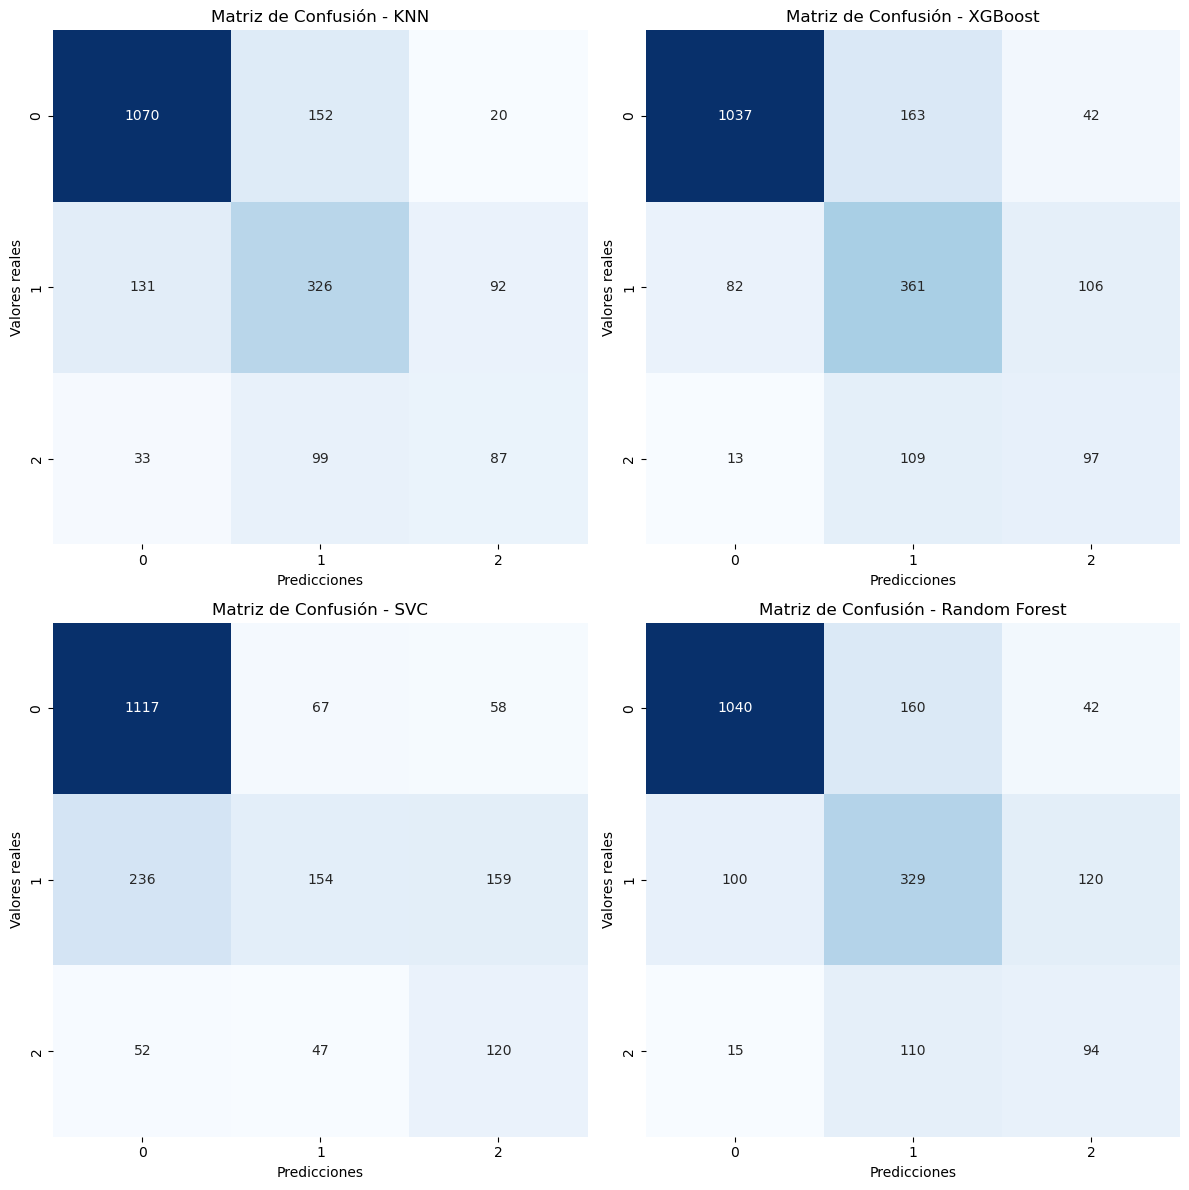

Accuracy de los modelos:
KNN: 0.74
XGBoost: 0.74
SVC: 0.69
Random Forest: 0.73


In [30]:

# Define los modelos
models = {
    'KNN': KNeighborsClassifier(),
    'XGBoost': xgb.XGBClassifier(),
    'SVC': SVC(),
    'Random Forest': RandomForestClassifier()
}

# Diccionario para almacenar accuracies
accuracies = {}

# Crear la cuadrícula de subgráficos
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

# Iterar sobre cada modelo y crear la matriz de confusión
for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    confusion = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[i])
    axs[i].set_xlabel('Predicciones')
    axs[i].set_ylabel('Valores reales')
    axs[i].set_title(f'Matriz de Confusión - {name}')
    
    # Agregar el classification report
    report = classification_report(y_test, y_pred)
    print(f'Model {name}:\n{report}')
    
    # Calcular y guardar la accuracy
    accuracy = accuracy_score(y_test, y_pred).round(2)
    accuracies[name] = accuracy

# Ajustar el diseño y mostrar los subgráficos
plt.tight_layout()
plt.show()

# Imprimir accuracies
print("Accuracy de los modelos:")
for model, accuracy in accuracies.items():
    print(f"{model}: {accuracy}")



Los modelos knn i xgboost son los que obtuvieron los mejores resultados. Aunque random forest y knn sacaron valores parecidos. Al final me decanté por xgboost porque tiene mejores resultados cuando trata de predecir la clasificacion de riesgo alto, y es lo que realmente interesa en este estudio.

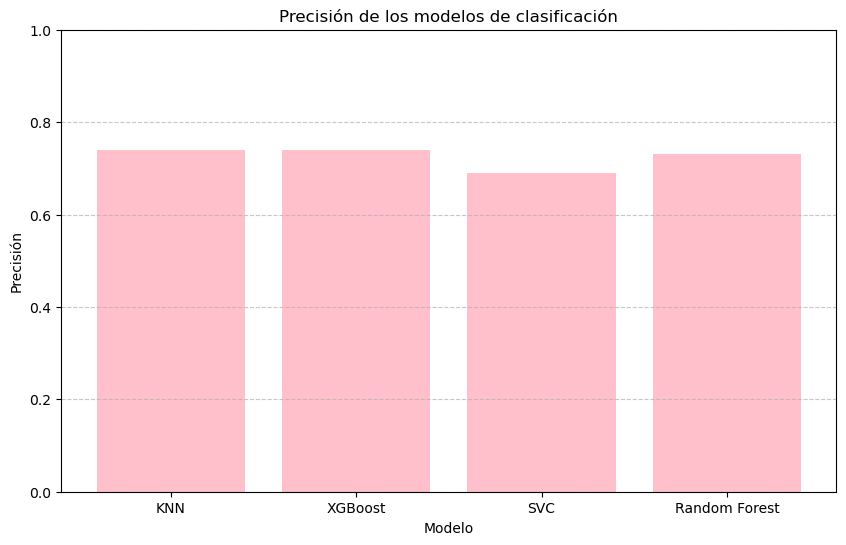

In [31]:
import matplotlib.pyplot as plt

# Datos de precisión de los modelos
modelos = list(accuracies.keys())
precisions = list(accuracies.values())

# Crear la visualización de barras
plt.figure(figsize=(10, 6))
plt.bar(modelos, precisions, color='pink')

# Añadir etiquetas y título
plt.xlabel('Modelo')
plt.ylabel('Precisión')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Precisión de los modelos de clasificación')

# Mostrar la visualización
plt.show()

In [32]:
# Definir los modelos
models = {
    'KNN': KNeighborsClassifier(),
    'XGBoost': xgb.XGBClassifier(),
    'SVC': SVC(),
    'Random Forest': RandomForestClassifier()
}

# Almacenar las medias de cross validation
mean_scores = {}

# Realizar la CV para cada modelo
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_scores[name] = np.mean(scores)
    print(f'{name}: Media CV: {scores.mean():.3f} Desviación estándar CV: {scores.std():.3f}')


KNN: Media CV: 0.746 Desviación estándar CV: 0.021
XGBoost: Media CV: 0.785 Desviación estándar CV: 0.036
SVC: Media CV: 0.572 Desviación estándar CV: 0.009
Random Forest: Media CV: 0.790 Desviación estándar CV: 0.032


Una desviación estándar más baja sugiere que el rendimiento del modelo es más consistente entre las diferentes divisiones, mientras que una desviación estándar más alta indica una mayor variabilidad en el rendimiento.

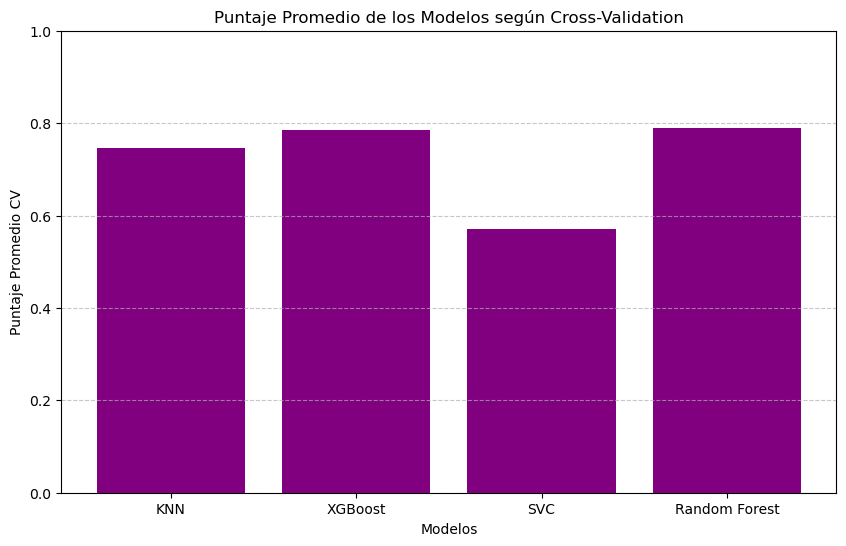

In [33]:
# Visualizar de los puntajes promedio
plt.figure(figsize=(10, 6))
plt.bar(mean_scores.keys(), mean_scores.values(), color='purple')
plt.xlabel('Modelos')
plt.ylabel('Puntaje Promedio CV')
plt.title('Puntaje Promedio de los Modelos según Cross-Validation')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Claramente se descarta el modelo SVC por su bajo rendimiento en Cross Validation, por lo que se usará GridSearch para buscar los hiperparámetros únciamente en los otros 3 modelos, knn, xgboost y random forest.

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [ 200, 300],
    'max_depth': [10, 20],
    'min_samples_split': [ 5, 10],
    'min_samples_leaf': [ 2, 4]
}

# Inicializar el modelo RandomForestClassifier con class_weight
rf = RandomForestClassifier()

# Crear un objeto GridSearchCV
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', verbose=1)

# Ajustar el modelo a los datos
grid_search_rf.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params_rf = grid_search_rf.best_params_

print("Mejores hiperparámetros:", best_params_rf)



Fitting 5 folds for each of 16 candidates, totalling 80 fits
Mejores hiperparámetros: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [35]:
# Acceder al mejor estimador desde GridSearchCV
best_estimator = grid_search_rf.best_estimator_

# Hacer predicciones con el mejor estimador
best_model_rf = best_estimator.predict(X_test)

# Calcular y mostrar el accuracy score para el mejor estimador
accuracy_rf_param = accuracy_score(y_test, best_model_rf).round(3)
print(f'Accuracy del modelo Random Forest hiperparam: {accuracy_rf_param}')
print(f"Accuracy del modelo Random Forest: {accuracies['Random Forest']}")


Accuracy del modelo Random Forest hiperparam: 0.737
Accuracy del modelo Random Forest: 0.73


No se aprecian mejoras con la implementación de los hiperparámetros

In [36]:
# Definimos los hiperparámetros que queremos probar
param_knn = {
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Creamos una instancia del clasificador KNN
knn = KNeighborsClassifier()

# Creamos una instancia de GridSearchCV
grid_search_knn = GridSearchCV(knn, param_knn, cv=5, scoring='accuracy')

# Ajustamos GridSearchCV al conjunto de entrenamiento
grid_search_knn.fit(X_train, y_train)

# Obtenemos los mejores hiperparámetros encontrados
knn_best_params = grid_search_knn.best_params_

# Mostramos los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados mediante Grid Search:", knn_best_params)


Mejores hiperparámetros encontrados mediante Grid Search: {'algorithm': 'auto', 'metric': 'manhattan', 'p': 1, 'weights': 'distance'}


In [37]:

# Inicializar y entrenar el modelo knn con los mejores hiperparámetros
model_knn = KNeighborsClassifier(**knn_best_params)
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)

# Calcular y mostrar el accuracy score para knn
accuracy_knn_param = accuracy_score(y_test, y_pred_knn).round(3)

print(f"Accuracy del modelo KNN: {accuracies['KNN']}")
print(f'Accuracy del modelo KNN hiperparam: {accuracy_knn_param}')

Accuracy del modelo KNN: 0.74
Accuracy del modelo KNN hiperparam: 0.744


Tampoco se detectan mejoras con la implementación de los hiperparámetros.

In [38]:
parameters_xgb = {
    'max_depth': [5, 7],                  
    'learning_rate': [0.1, 0.3],                   
    'subsample': [0.8, 1.0],    
    'colsample_bytree': [0.8, 1.0],        
}

# Inicializar el modelo XGBClassifier
model_xgb = xgb.XGBClassifier()

# Crear un objeto GridSearchCV
grid_search_xgb = GridSearchCV(model_xgb, parameters_xgb, cv=5, scoring='accuracy', verbose=1)

# Ajustar el modelo a los datos
grid_search_xgb.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params_xgb = grid_search_xgb.best_params_

print("Mejores hiperparámetros:", best_params_xgb)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Mejores hiperparámetros: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 7, 'subsample': 0.8}


In [39]:
# Modelo XGBoost mejores hiperparámetros

# Inicializar y entrenar el modelo XGB con los mejores hiperparámetros
model_xgb = xgb.XGBClassifier(**best_params_xgb)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

# Calcular y mostrar el accuracy score para XGBoost
accuracy_xgb_param = accuracy_score(y_test, y_pred_xgb).round(3)

print(f"Accuracy del modelo XGBoost: {accuracies['XGBoost']}")
print(f'Accuracy del modelo XGBoost hiperparam: {accuracy_xgb_param}')

Accuracy del modelo XGBoost: 0.74
Accuracy del modelo XGBoost hiperparam: 0.748


Ninguno de los modelos mejora su accuracy una vez aplicaos los mejores hiperparámetros encontrados. Por lo que finalmente se considera que el modelo que mejor se ajusta es XGboost, ya que se trata de un modelo  que tiene muy poca sensibilidad con la disparidad en las clases, lo cual te conviene en este estudio. Además ha obtenido los mejores resultados en el CV conjuntamente con el Random Forest. Pero si se tienen en cuenta las métricas en la matriz de confusión, XGBoost obtiene mejores resultados en las clases 2 y 3, que son las que interesan identificar con mayor rotundidad debido a que se identifican como las de mayor riesgo.

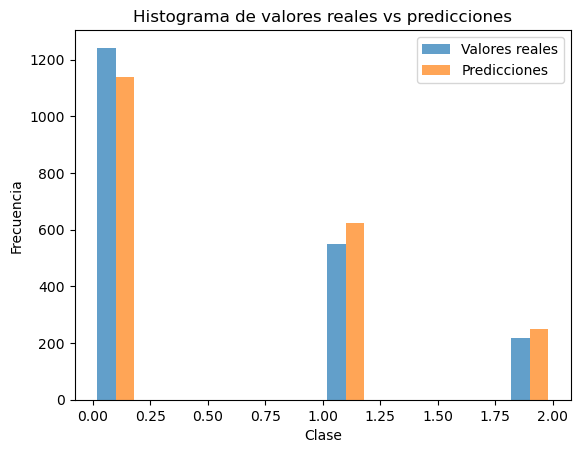

In [42]:
#las predicciones del mejor modelo
# y 'y_test' son los valores reales del conjunto de prueba
plt.hist([y_test, y_pred_xgb], bins=10, alpha=0.7, label=['Valores reales', 'Predicciones'])
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.title('Histograma de valores reales vs predicciones')
plt.legend()

Se comprueba que efectivamente el rendimiento del modelo xgboost es óptimo, teniendo en cuenta los valores de train y test.

In [62]:
df.columns

Index(['espai_id', 'semafor', 'punt_trobada', 'proximitat_recurs',
       'lloc_pernocta', 'homes', 'dones', 'consum'],
      dtype='object')

In [61]:
#deberia ser 2


nueva_fila2 = {'espai_id':0, 'punt_trobada':1, 'proximitat_recurs':1, 'lloc_pernocta':1,
       'homes':3, 'dones':1, 'consum':2.3}


# Crear DataFrame a partir de la nueva fila
nueva_fila_df = pd.DataFrame([nueva_fila2])

# Añadir la nueva fila al DataFrame existente
df= df.append(nueva_fila_df, ignore_index=False)

# Hacer la predicción con el modelo
prediction = model_xgb.predict(nueva_fila_df)

print(f'La predicción es {prediction}')


La predicción es [2]


In [60]:
#esto deberia ser 1


nueva_fila1 = { 'espai_id':8, 'punt_trobada':1, 'proximitat_recurs':0, 'lloc_pernocta':0,
       'homes':-0.32, 'dones':0, 'consum':1}


# Crear DataFrame a partir de la nueva fila
nueva_fila_df = pd.DataFrame([nueva_fila1])

# Añadir la nueva fila al DataFrame existente
df = df.append(nueva_fila_df, ignore_index=False)

# Hacer la predicción con el modelo
prediction = model_xgb.predict(nueva_fila_df)

print(f'La predicción es {prediction}')

La predicción es [1]


In [59]:
#esto deberia ser 0
nueva_fila0 ={'espai_id':0,'punt_trobada':0, 'proximitat_recurs':0, 'lloc_pernocta':0,
       'homes':0, 'dones':0, 'consum':0}



# Crear DataFrame a partir de la nueva fila
nueva_fila_df = pd.DataFrame([nueva_fila0])

# Añadir la nueva fila al DataFrame existente
df = df.append(nueva_fila_df, ignore_index=False)

# Hacer la predicción con el modelo
prediction = model_xgb.predict(nueva_fila_df)

print(f'La predicción es {prediction}')

La predicción es [0]


In [57]:
#Guardar df en archivo csv
df.to_csv('dades_feb.csv', index=False)

In [58]:
dump(model_xgb, "model_xgb.joblib")


['model_xgb.joblib']